In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Introduction
* Finding the relationship between the composition/structure and properties of materials is a holy grail of material science. Various models ranging from QM methods on the atomic scale to FEM on the macroscopic scale have been developed in the past century. More recently, ML-based approaches have gained momentum.
* Here, we provide a toy dataset of alloys toy_alloy_data.csv. The first 12 columns correspond to the proportion of 12 elements (i.e. the first 12 columns of any row should sum to 1). The last 6 columns correspond to 6 properties (Each property column has been normalised so that its mean and standard deviation are 0 and 1, respectively)
* We will analyze the data and use various Machine Learning techniques to solve the tasks in hand.

#### Read and store data

In [2]:
toy_alloy_data = pd.read_csv("toy_alloy_data.csv")
size = len(toy_alloy_data)

X_name = [f'element {i}' for i in range(1,13)]
Y_name = [f'property {i}' for i in range(1,7)]
print(toy_alloy_data.head(10))

   element 1  element 2  element 3  element 4  element 5  element 6  \
0   0.693551   0.199083   0.055558   0.032409   0.009260   0.009260   
1   0.009337   0.000000   0.009337   0.308123   0.000000   0.659197   
2   0.956573   0.009781   0.008803   0.000000   0.016628   0.000978   
3   0.301588   0.253547   0.013345   0.400338   0.017793   0.006672   
4   0.946832   0.000000   0.008616   0.037207   0.004406   0.000000   
5   0.964912   0.002924   0.016569   0.004873   0.004873   0.002924   
6   0.004570   0.003555   0.000102   0.000000   0.004570   0.000508   
7   0.993127   0.000000   0.004981   0.000000   0.000000   0.000000   
8   0.000484   0.000000   0.000000   0.000000   0.000000   0.813559   
9   0.000484   0.000000   0.000000   0.000000   0.000000   0.677310   

   element 7  element 8  element 9  element 10  element 11  element 12  \
0   0.000324   0.000278   0.000278    0.000000    0.000000    0.000000   
1   0.000000   0.000000   0.000000    0.009337    0.004669    0.000000

In [3]:
toy_alloy_data.describe()

,element 1,element 2,element 3,element 4,element 5,element 6,element 7,element 8,element 9,element 10,element 11,element 12,property 1,property 2,property 3,property 4,property 5,property 6
count,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03,4.612000e+03
mean,0.419336,0.040728,0.009421,0.042242,0.007931,0.203768,0.000311,0.001710,0.000181,0.032633,0.001262,0.240479,-3.191470e-16,-4.357120e-17,8.902005e-17,-1.714683e-16,-1.644965e-13,-3.322003e-17
std,0.435785,0.076945,0.016830,0.115915,0.016362,0.362367,0.000952,0.004197,0.000389,0.104186,0.001974,0.411919,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00,1.000108e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.082560e-01,-1.148295e+00,-2.919913e+00,-9.310694e-01,-2.724788e+01,-1.207390e+00
25%,0.003968,0.000000,0.000991,0.000000,0.000996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.082560e-01,-1.044864e+00,-4.468705e-01,-9.240504e-01,1.750028e-02,-8.248388e-01
50%,0.051852,0.001395,0.007878,0.000000,0.003957,0.002470,0.000237,0.000201,0.000090,0.000000,0.000000,0.000000,-1.082560e-01,-4.368803e-01,1.533713e-01,-6.737728e-01,2.279300e-02,-1.572499e-01
75%,0.948544,0.013826,0.010929,0.016726,0.008841,0.049140,0.000349,0.001947,0.000281,0.002451,0.001513,0.389568,-9.935497e-02,1.192823e+00,8.322118e-01,1.285551e+00,2.367406e-02,5.178401e-01
max,0.999350,0.581123,0.413413,0.986388,0.190476,1.000000,0.015780,0.037486,0.006713,0.999920,0.014677,0.996910,5.467245e+01,1.315811e+00,8.443982e-01,1.430488e+00,3.963239e+01,1.229441e+01


### Task 1: Handling missing data

For each row, the sum of proportion of elements should be equal to 1. Therefore, for a missing value of element X, we can replace it the following way:

Let in ith row, element X is missing. Let mean of X over all data = m.

Let sum of all other elements in that row be s.

replace Xth cell of ith row by m*(1-s)/sum(mean of all missing elements)

Missing values of properties can be replaced by their mean over all data.

##### Correlation heatmap of input features

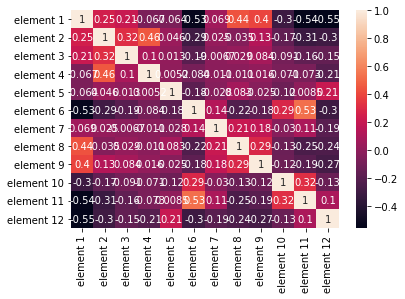

In [5]:
in_df = toy_alloy_data[X_name]
corrMatrix = in_df.corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

### Task 2: Predicting properties from composition of materials
* Here we show how to train a simple neural network model for the composition to property problem using PyTorch.

Note: In the code below, we did not split the data into training, validation and testing sets, which you probably should not do.

In [6]:
# a simple training procedure with MSE loss and Adam optimiser
def train(x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(12, 12), nn.Tanh(), nn.Linear(12, 9), nn.Tanh(), nn.Linear(9, 6))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.4f}, R^2: {float(R2):.4f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [7]:
X = torch.tensor(toy_alloy_data[X_name].values)
Y = torch.tensor(toy_alloy_data[Y_name].values)

In [8]:
m, loss_hist, R2_hist= train(X, Y, max_iter=30000)

epoch: 1000, loss: 0.4859, R^2: 0.5141
epoch: 2000, loss: 0.4657, R^2: 0.5343
epoch: 3000, loss: 0.4517, R^2: 0.5483
epoch: 4000, loss: 0.4259, R^2: 0.5741
epoch: 5000, loss: 0.3863, R^2: 0.6137
epoch: 6000, loss: 0.3539, R^2: 0.6461
epoch: 7000, loss: 0.3301, R^2: 0.6699
epoch: 8000, loss: 0.3110, R^2: 0.6890
epoch: 9000, loss: 0.2972, R^2: 0.7028
epoch: 10000, loss: 0.2859, R^2: 0.7141
epoch: 11000, loss: 0.2743, R^2: 0.7257
epoch: 12000, loss: 0.2612, R^2: 0.7388
epoch: 13000, loss: 0.2491, R^2: 0.7509
epoch: 14000, loss: 0.2361, R^2: 0.7639
epoch: 15000, loss: 0.2219, R^2: 0.7781
epoch: 16000, loss: 0.2021, R^2: 0.7979
epoch: 17000, loss: 0.1853, R^2: 0.8147
epoch: 18000, loss: 0.1754, R^2: 0.8246
epoch: 19000, loss: 0.1683, R^2: 0.8317
epoch: 20000, loss: 0.1627, R^2: 0.8373
epoch: 21000, loss: 0.1582, R^2: 0.8418
epoch: 22000, loss: 0.1546, R^2: 0.8454
epoch: 23000, loss: 0.1516, R^2: 0.8484
epoch: 24000, loss: 0.1492, R^2: 0.8508
epoch: 25000, loss: 0.1474, R^2: 0.8526
epoch: 26

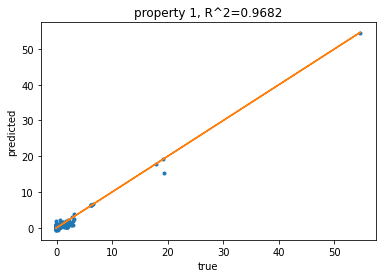

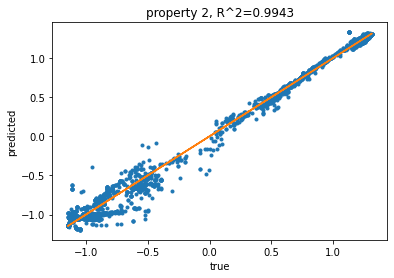

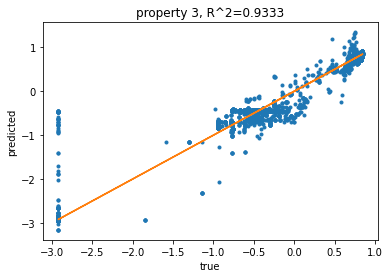

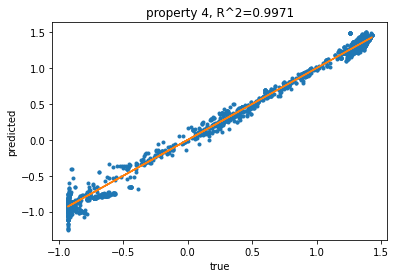

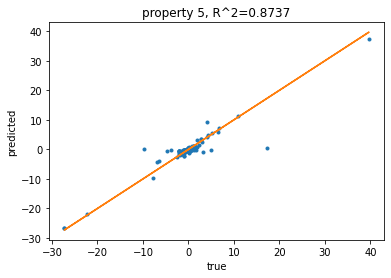

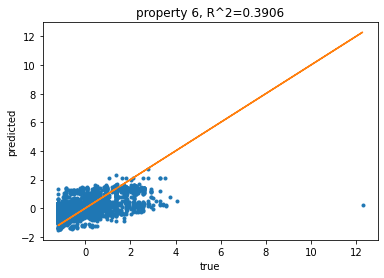

In [9]:
with torch.no_grad():
    Y_pred = m(X).numpy()
Y_true = Y.numpy()

for i in range(6):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

The above code was provided to us by DeepVerse. The performance of the NN model above seems not too bad.
But, it can be improved by training the Neural Network model to predict for each property seperately. This means that our neural network will have 12 input features and 1 target value.
Here is the implementation of the above idea.

In [10]:
def train12to1(i, x, y,  max_iter=20000):
    
    m = nn.Sequential(nn.Linear(12, 12), nn.Tanh(), nn.Linear(12,6), nn.Tanh(), nn.Linear(6,1))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    print(f'training for property {i}')
    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.4f}, R^2: {float(R2):.4f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [11]:
X = torch.tensor(toy_alloy_data[X_name].values)
Y = torch.tensor(toy_alloy_data[Y_name].values)
Y_pred = np.empty((size, 6))

for i in range(6):
    target = [Y_name[i]]
    Y = torch.tensor(toy_alloy_data[target].values)
    m, loss_hist, R2_hist= train12to1(i+1, X, Y, max_iter=20000)
    with torch.no_grad():
        y_pred_i = m(X).numpy()
    for j in range(size):
        Y_pred[j][i] = y_pred_i[j]

training for property 1
epoch: 1000, loss: 0.8649, R^2: 0.1351
epoch: 2000, loss: 0.7291, R^2: 0.2709
epoch: 3000, loss: 0.5260, R^2: 0.4740
epoch: 4000, loss: 0.3559, R^2: 0.6441
epoch: 5000, loss: 0.2755, R^2: 0.7245
epoch: 6000, loss: 0.2225, R^2: 0.7775
epoch: 7000, loss: 0.1877, R^2: 0.8123
epoch: 8000, loss: 0.1649, R^2: 0.8351
epoch: 9000, loss: 0.1518, R^2: 0.8482
epoch: 10000, loss: 0.1453, R^2: 0.8547
epoch: 11000, loss: 0.1426, R^2: 0.8574
epoch: 12000, loss: 0.1415, R^2: 0.8585
epoch: 13000, loss: 0.1410, R^2: 0.8590
epoch: 14000, loss: 0.1406, R^2: 0.8594
epoch: 15000, loss: 0.1403, R^2: 0.8597
epoch: 16000, loss: 0.1399, R^2: 0.8601
epoch: 17000, loss: 0.1396, R^2: 0.8604
epoch: 18000, loss: 0.1392, R^2: 0.8608
epoch: 19000, loss: 0.1389, R^2: 0.8611
epoch: 20000, loss: 0.1385, R^2: 0.8615
training for property 2
epoch: 1000, loss: 0.0099, R^2: 0.9901
epoch: 2000, loss: 0.0046, R^2: 0.9954
epoch: 3000, loss: 0.0018, R^2: 0.9982
epoch: 4000, loss: 0.0011, R^2: 0.9989
epoch

#### Result

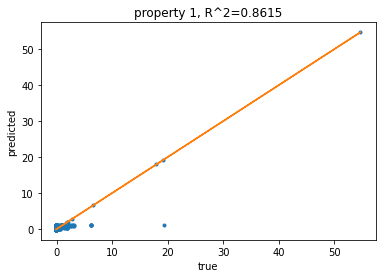

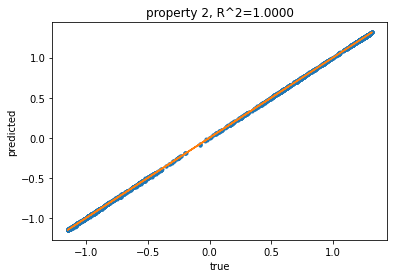

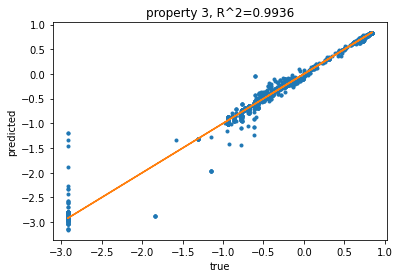

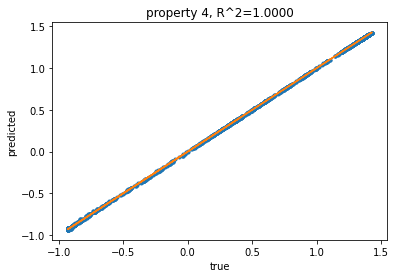

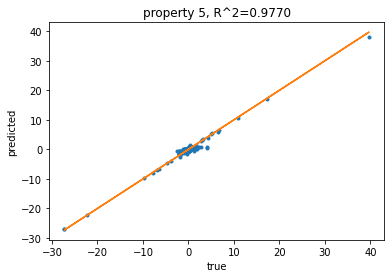

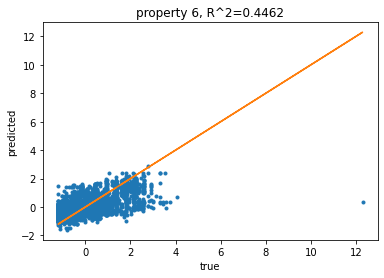

In [12]:
Y = torch.tensor(toy_alloy_data[Y_name].values)
Y_true = Y.numpy()

for i in range(6):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

As you can see, the R-squared score has improved.

### Task 3: Predicting the composition of elements from the properties

Here we have used various machine learning models to predict the compositions.

Note that here, we have to compare the Regression models with the Neural Network models. Therefore we have no other choice but to split the data into training and testing data in a ratio 75:25.
I have also provided a notebook DeepVerse_Challenege-2.ipynb where I have trained the models on the whole dataset. For results on the complete dataset, please refer to DeepVerse_Challenege-2.ipynb

In [13]:
Y_name = [f'element {i}' for i in range(1,13)]
X_name = [f'property {i}' for i in range(1,7)]

##### Correlation heatmap of input features

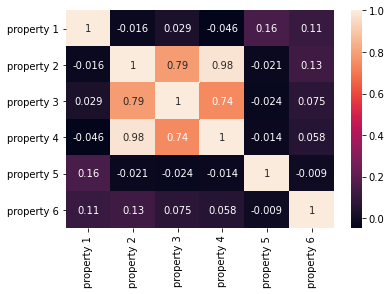

In [14]:
in_df = toy_alloy_data[X_name]
corrMatrix = in_df.corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

In [15]:
# helper function
# normalizes the predicted composition of each element to within the range 0 to 1
def normalize_results(Y):
    for i in range(len(Y)):
        sum = 0
        for j in range(len(Y[0])):
            if Y[i][j] < 0:
                Y[i][j] = 0
            sum = sum + Y[i][j]
        for j in range(len(Y[0])):
            Y[i][j] = Y[i][j]/sum
    return Y

#### Model 1: Simple Neural Network with 6 input features and 12 output features

In [16]:
# a simple training procedure with MSE loss and Adam optimiser
def train6to12(x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(6, 6), nn.Tanh(), nn.Linear(6, 15), nn.Tanh(), nn.Linear(15, 12))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.8f}, R^2: {float(R2):.8f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [17]:
X = torch.tensor(toy_alloy_data[X_name].values)
Y = torch.tensor(toy_alloy_data[Y_name].values)

In [18]:
m, loss_hist, R2_hist= train6to12(X, Y, max_iter=30000)

epoch: 1000, loss: 0.00950677, R^2: -20.38897878
epoch: 2000, loss: 0.00873377, R^2: -37.77399635
epoch: 3000, loss: 0.00720505, R^2: -50.50791315
epoch: 4000, loss: 0.00618904, R^2: -36.09750974
epoch: 5000, loss: 0.00581976, R^2: -19.47288545
epoch: 6000, loss: 0.00551384, R^2: -10.56938022
epoch: 7000, loss: 0.00534416, R^2: -6.11575419
epoch: 8000, loss: 0.00523492, R^2: -1.41255130
epoch: 9000, loss: 0.00513602, R^2: -0.58856004
epoch: 10000, loss: 0.00505103, R^2: -0.44535173
epoch: 11000, loss: 0.00495509, R^2: -0.03801673
epoch: 12000, loss: 0.00487864, R^2: 0.41537314
epoch: 13000, loss: 0.00475949, R^2: 0.52542102
epoch: 14000, loss: 0.00459494, R^2: 0.51556247
epoch: 15000, loss: 0.00445440, R^2: 0.53766948
epoch: 16000, loss: 0.00432929, R^2: 0.57025170
epoch: 17000, loss: 0.00425482, R^2: 0.57522297
epoch: 18000, loss: 0.00421048, R^2: 0.50307380
epoch: 19000, loss: 0.00417765, R^2: 0.54590496
epoch: 20000, loss: 0.00414012, R^2: 0.57223428
epoch: 21000, loss: 0.00410160, 

MSE : 0.003813962994803672


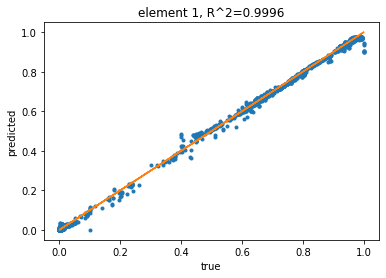

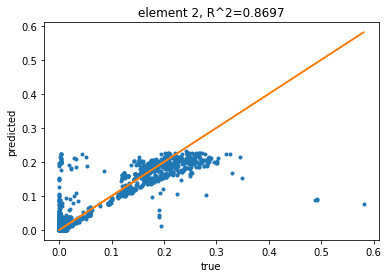

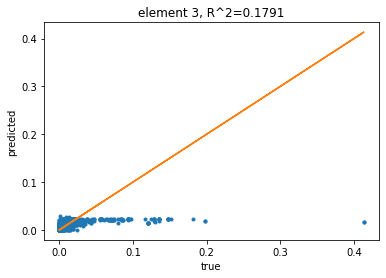

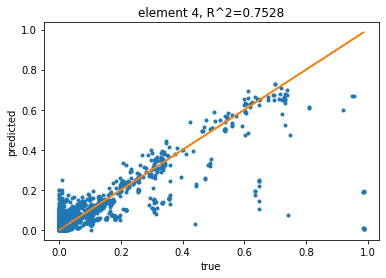

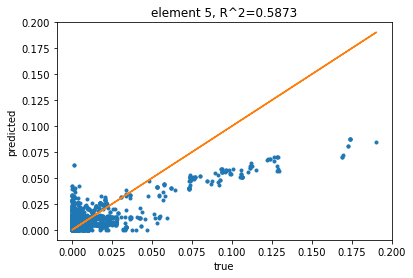

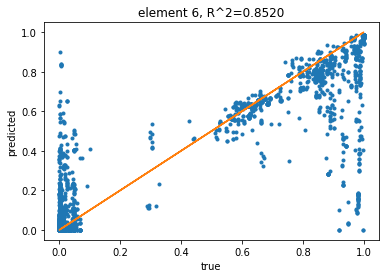

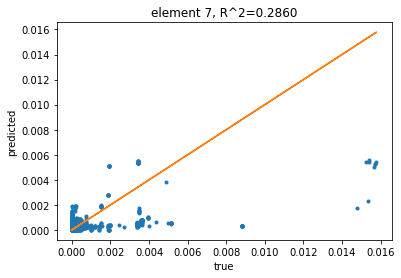

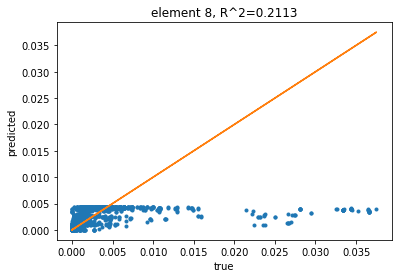

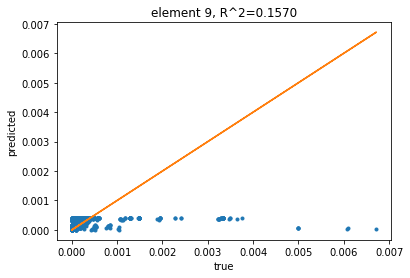

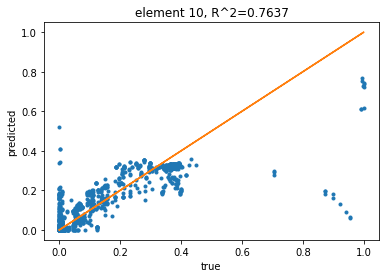

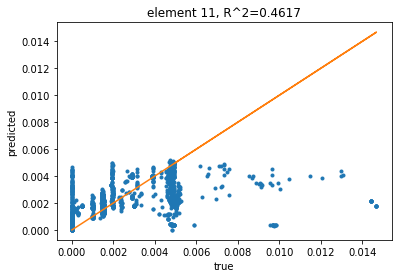

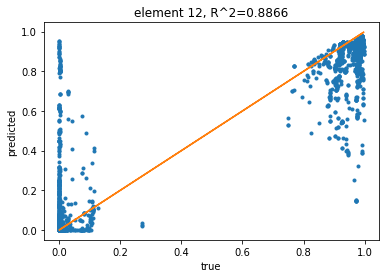

In [19]:
with torch.no_grad():
    Y_pred = m(X).numpy()
Y_true = Y.numpy()

Y_pred = normalize_results(Y_pred) 

print(f'MSE : {mean_squared_error(Y_true, Y_pred)}')    


for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

#### Model 2: Simple Neural Network that predicts proportion of each element in the material seperately (i.e. 6 input features and 1 target value)

In [20]:
# a simple training procedure with MSE loss and Adam optimiser
def train6to1(i, x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(6, 6), nn.Tanh(), nn.Linear(6, 3), nn.Tanh(), nn.Linear(3, 1))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)
        
    print(f'training for element {i}')

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.8f}, R^2: {float(R2):.8f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [23]:
Y_pred = np.empty((size, 12)) #2darray that stores prediction on data

for i in range(12):
    target = [Y_name[i]]
    curr_Y = torch.tensor(toy_alloy_data[target].values)
    m, loss_hist, R2_hist= train6to1(i+1, X, curr_Y, max_iter=30000)
        
    with torch.no_grad():
        y_pred_i = m(X).numpy()
    for j in range(size):
        Y_pred[j][i] = y_pred_i[j]

training for element 1
epoch: 1000, loss: 0.00128785, R^2: 0.99321711
epoch: 2000, loss: 0.00065061, R^2: 0.99657336
epoch: 3000, loss: 0.00042946, R^2: 0.99773812
epoch: 4000, loss: 0.00028333, R^2: 0.99850777
epoch: 5000, loss: 0.00017796, R^2: 0.99906273
epoch: 6000, loss: 0.00010712, R^2: 0.99943580
epoch: 7000, loss: 0.00006073, R^2: 0.99968016
epoch: 8000, loss: 0.00003350, R^2: 0.99982356
epoch: 9000, loss: 0.00001922, R^2: 0.99989878
epoch: 10000, loss: 0.00001118, R^2: 0.99994112
epoch: 11000, loss: 0.00000795, R^2: 0.99995810
epoch: 12000, loss: 0.00000547, R^2: 0.99997117
epoch: 13000, loss: 0.00000443, R^2: 0.99997668
epoch: 14000, loss: 0.00000372, R^2: 0.99998041
epoch: 15000, loss: 0.00000318, R^2: 0.99998325
epoch: 16000, loss: 0.00000275, R^2: 0.99998552
epoch: 17000, loss: 0.00000241, R^2: 0.99998728
epoch: 18000, loss: 0.00000216, R^2: 0.99998865
epoch: 19000, loss: 0.00000194, R^2: 0.99998976
epoch: 20000, loss: 0.00000177, R^2: 0.99999069
epoch: 21000, loss: 0.0000

epoch: 20000, loss: 0.02664529, R^2: 0.79703628
epoch: 21000, loss: 0.02649844, R^2: 0.79815488
epoch: 22000, loss: 0.02637102, R^2: 0.79912549
epoch: 23000, loss: 0.02626340, R^2: 0.79994522
epoch: 24000, loss: 0.02617687, R^2: 0.80060437
epoch: 25000, loss: 0.02610607, R^2: 0.80114365
epoch: 26000, loss: 0.02604551, R^2: 0.80160500
epoch: 27000, loss: 0.02599166, R^2: 0.80201517
epoch: 28000, loss: 0.02594032, R^2: 0.80240623
epoch: 29000, loss: 0.02588530, R^2: 0.80282533
epoch: 30000, loss: 0.02582100, R^2: 0.80331515
training for element 7
epoch: 1000, loss: 0.00004439, R^2: -47.99871085
epoch: 2000, loss: 0.00000907, R^2: -9.00711255
epoch: 3000, loss: 0.00000376, R^2: -3.15236274
epoch: 4000, loss: 0.00000170, R^2: -0.87391088
epoch: 5000, loss: 0.00000110, R^2: -0.21443051
epoch: 6000, loss: 0.00000096, R^2: -0.05561585
epoch: 7000, loss: 0.00000087, R^2: 0.04268611
epoch: 8000, loss: 0.00000080, R^2: 0.11898177
epoch: 9000, loss: 0.00000075, R^2: 0.17103405
epoch: 10000, loss:

epoch: 9000, loss: 0.02509855, R^2: 0.85204876
epoch: 10000, loss: 0.02426473, R^2: 0.85696400
epoch: 11000, loss: 0.02347541, R^2: 0.86161685
epoch: 12000, loss: 0.02231577, R^2: 0.86845274
epoch: 13000, loss: 0.02151240, R^2: 0.87318843
epoch: 14000, loss: 0.02103541, R^2: 0.87600022
epoch: 15000, loss: 0.02062962, R^2: 0.87839227
epoch: 16000, loss: 0.02027357, R^2: 0.88049113
epoch: 17000, loss: 0.01984523, R^2: 0.88301614
epoch: 18000, loss: 0.01918913, R^2: 0.88688367
epoch: 19000, loss: 0.01888346, R^2: 0.88868556
epoch: 20000, loss: 0.01865257, R^2: 0.89004659
epoch: 21000, loss: 0.01807652, R^2: 0.89344233
epoch: 22000, loss: 0.01773311, R^2: 0.89546666
epoch: 23000, loss: 0.01752090, R^2: 0.89671759
epoch: 24000, loss: 0.01730188, R^2: 0.89800868
epoch: 25000, loss: 0.01717883, R^2: 0.89873405
epoch: 26000, loss: 0.01708133, R^2: 0.89930878
epoch: 27000, loss: 0.01699818, R^2: 0.89979893
epoch: 28000, loss: 0.01692348, R^2: 0.90023925
epoch: 29000, loss: 0.01676860, R^2: 0.90

MSE : 0.0036365450599254306


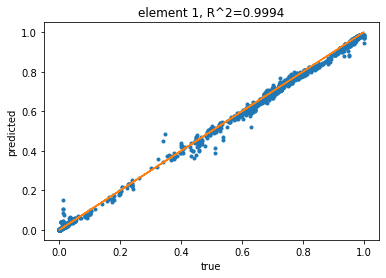

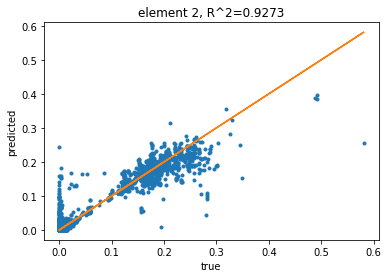

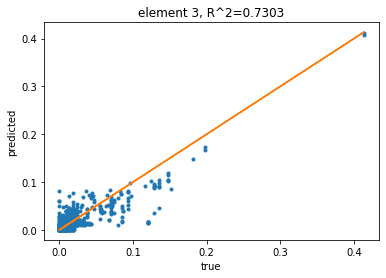

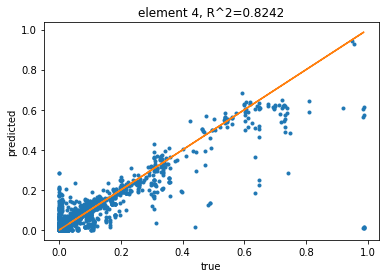

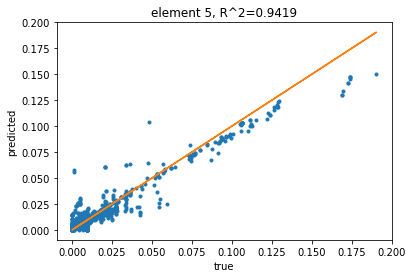

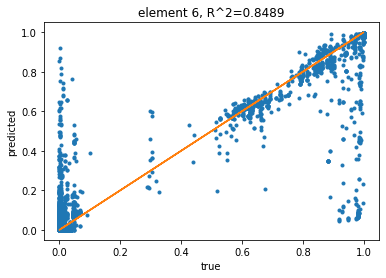

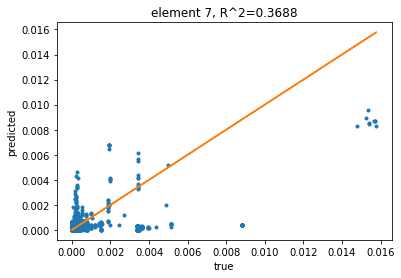

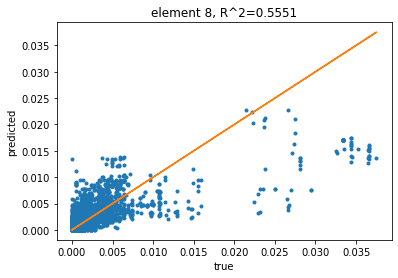

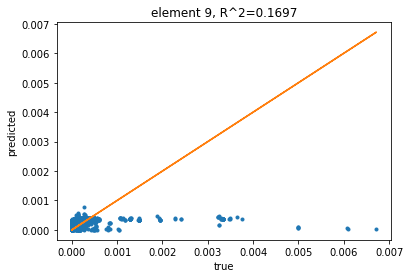

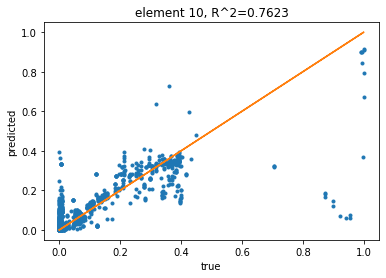

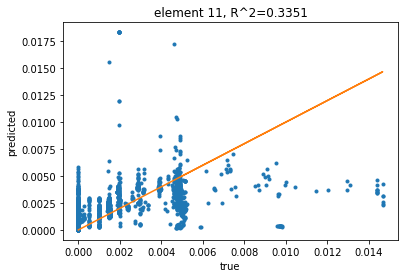

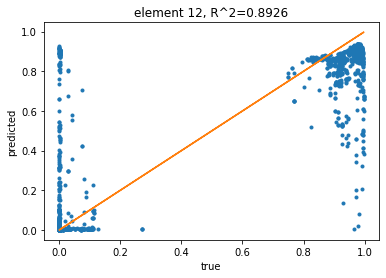

In [24]:
Y_true = Y.numpy()

Y_pred = normalize_results(Y_pred)

print(f'MSE : {mean_squared_error(Y_true, Y_pred)}')    

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

Now we can do one more thing. To predict the proportion of an element X in the current material, we can consider all the properties as well as the proportion of elements other that X in the current material as the input features.

#### Model 3: Simple Neural Network that predicts proportion of each element in the material seperately using 17 input features (i.e. 6 property features + 11 elements proportion features)

In [25]:
# a simple training procedure with MSE loss and Adam optimiser
def train17to1(i, x, y,  max_iter=20000):
    # a simple MLP with three hidden layers and tanh activation
    m = nn.Sequential(nn.Linear(17, 17), nn.Tanh(), nn.Linear(17, 8), nn.Tanh(), nn.Linear(8, 1))
    m.double()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)
       
    print(f'training for element {i}')

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_hist.append(loss.detach())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach())
            print(f'epoch: {t}, loss: {float(loss.item()):.8f}, R^2: {float(R2):.8f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-6:
                break
    return m, loss_hist, R2_hist

In [27]:
Y_pred = np.empty((size, 12)) #2darray that stores prediction on data

curr_X = X_name + Y_name #names of features currently acting as input
for i in range(12):
    target = [Y_name[i]]
    curr_X.remove(target[0])
    trainX = torch.tensor(toy_alloy_data[curr_X].values)
    
    trainY = torch.tensor(toy_alloy_data[target].values) #outputs for the current iteration
    
    m, loss_hist, R2_hist= train17to1(i+1, trainX, trainY, max_iter=10000)
        
    with torch.no_grad():
        y_pred_i = m(trainX).numpy()
    for j in range(size):
        Y_pred[j][i] = y_pred_i[j]
        
    curr_X.extend(target)
    

training for element 1
epoch: 1000, loss: 0.00025526, R^2: 0.99865557
epoch: 2000, loss: 0.00011014, R^2: 0.99941991
epoch: 3000, loss: 0.00005006, R^2: 0.99973633
epoch: 4000, loss: 0.00002956, R^2: 0.99984433
epoch: 5000, loss: 0.00001659, R^2: 0.99991264
epoch: 6000, loss: 0.00000881, R^2: 0.99995360
epoch: 7000, loss: 0.00000547, R^2: 0.99997121
epoch: 8000, loss: 0.00000322, R^2: 0.99998306
epoch: 9000, loss: 0.00000205, R^2: 0.99998921
epoch: 10000, loss: 0.00000124, R^2: 0.99999346
training for element 2
epoch: 1000, loss: 0.00011098, R^2: 0.98125123
epoch: 2000, loss: 0.00001338, R^2: 0.99774017
epoch: 3000, loss: 0.00000208, R^2: 0.99964927
epoch: 4000, loss: 0.00000116, R^2: 0.99980334
epoch: 5000, loss: 0.00000079, R^2: 0.99986587
epoch: 6000, loss: 0.00000081, R^2: 0.99986251
epoch: 7000, loss: 0.00000038, R^2: 0.99993498
epoch: 8000, loss: 0.00000044, R^2: 0.99992518
epoch: 9000, loss: 0.00000024, R^2: 0.99996008
epoch: 10000, loss: 0.00000019, R^2: 0.99996721
training for

MSE : 9.85245348021042e-07


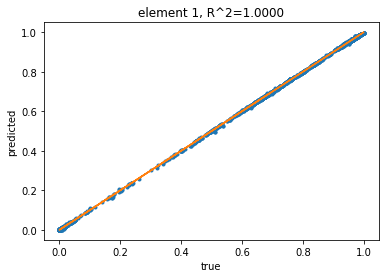

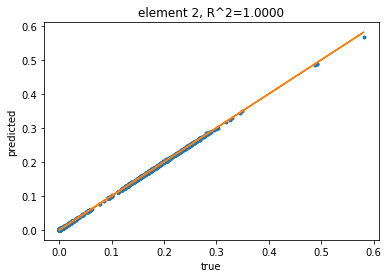

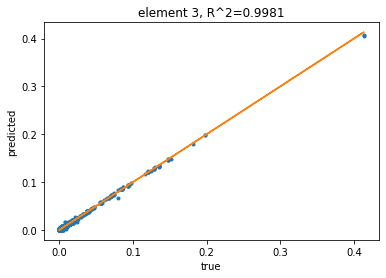

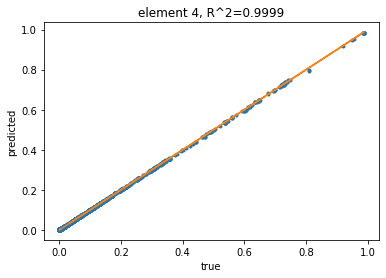

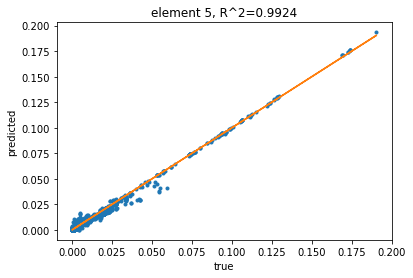

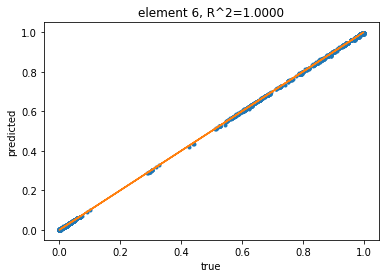

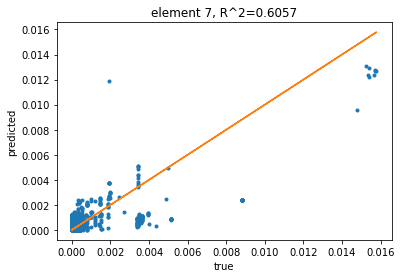

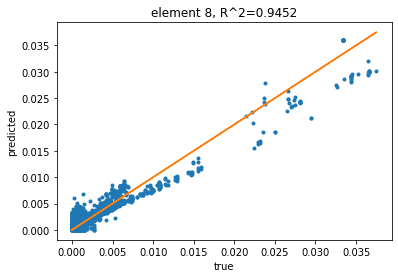

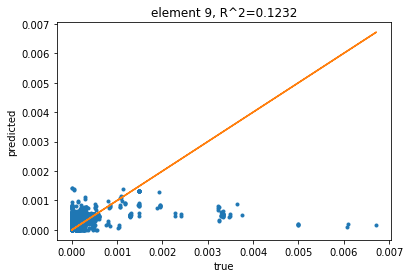

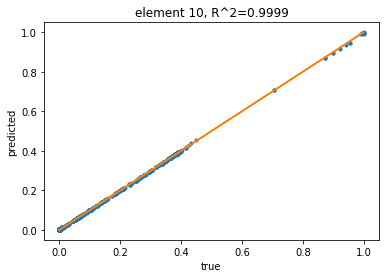

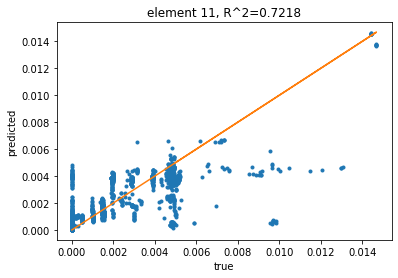

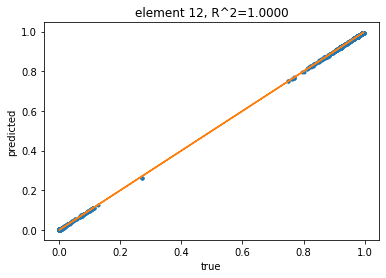

In [28]:
Y = torch.tensor(toy_alloy_data[Y_name].values) #overall output

Y_true = Y.numpy()

Y_pred = normalize_results(Y_pred)

print(f'MSE : {mean_squared_error(Y_true, Y_pred)}')   

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

#### Model 4: Linear Regression

In [29]:
X = toy_alloy_data[X_name]
Y = toy_alloy_data[Y_name]


In [30]:
def trainRegressor(x, y):
    m = LinearRegression()
    m.fit(x, y)
    return m

MSE : 0.010646800489095878


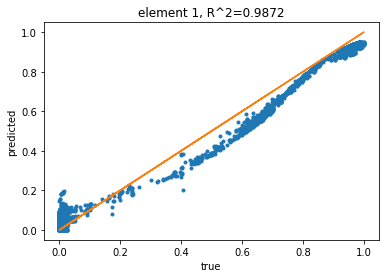

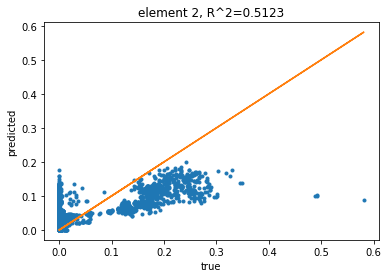

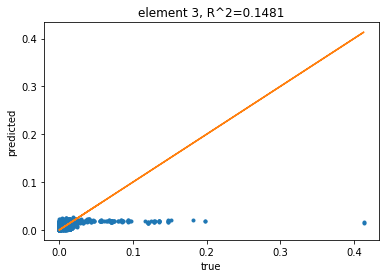

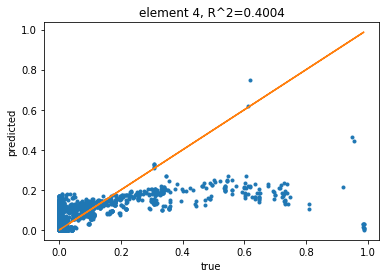

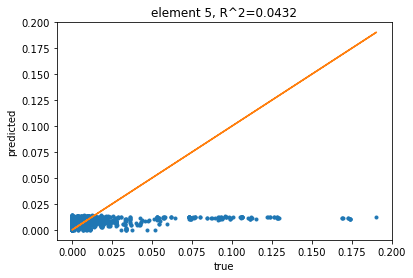

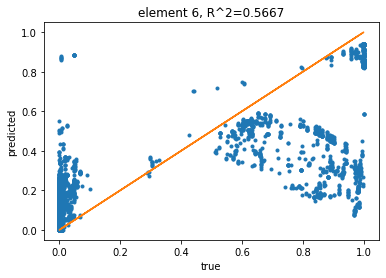

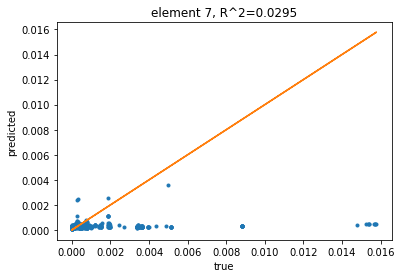

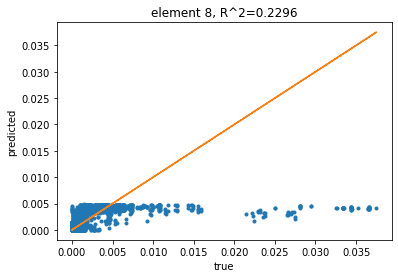

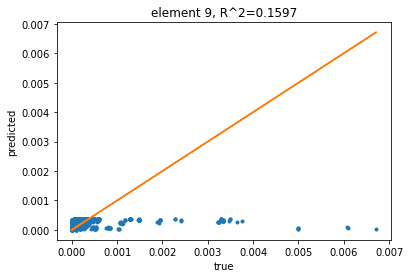

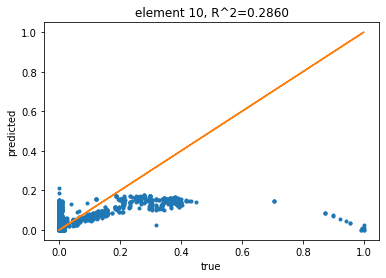

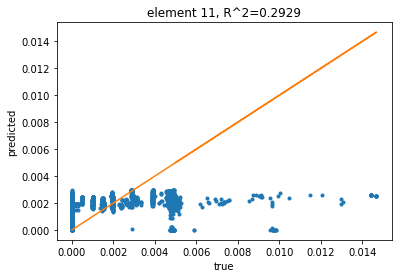

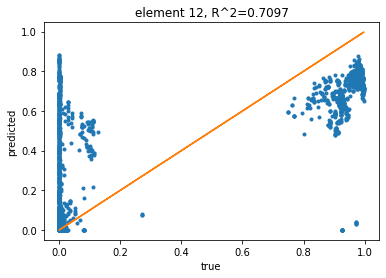

In [31]:
m = trainRegressor(X, Y)

Y_pr = m.predict(X)

Y_pr = normalize_results(Y_pr)

print(f'MSE : {mean_squared_error(Y, Y_pr)}')   

Y_true = np.array(Y)
Y_pred = np.array(Y_pr)


for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()

#### Model 5: K Nearest Neighbour Regression

In [32]:
def train_KNN(x, y):
    m = KNeighborsRegressor()
    m.fit(x, y)
    return m

MSE : 0.0032133454629799346


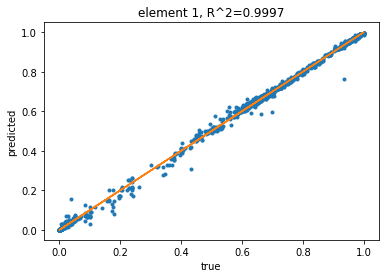

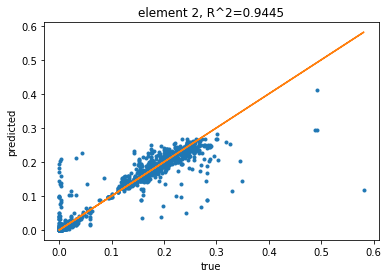

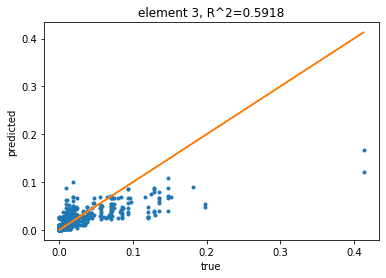

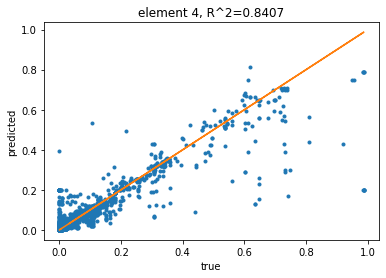

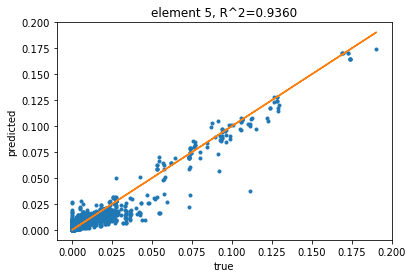

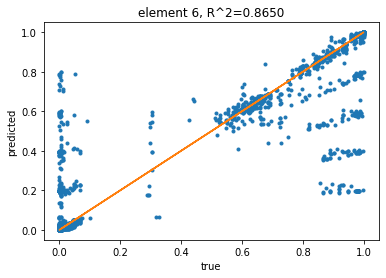

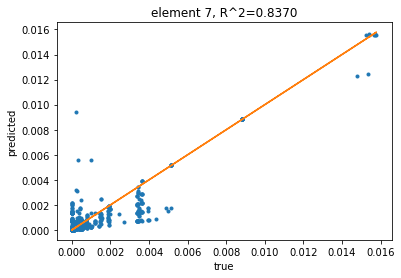

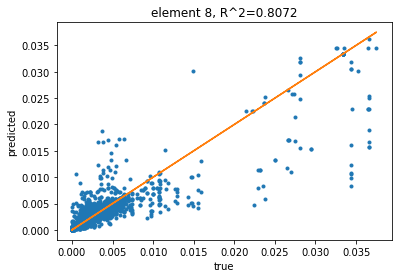

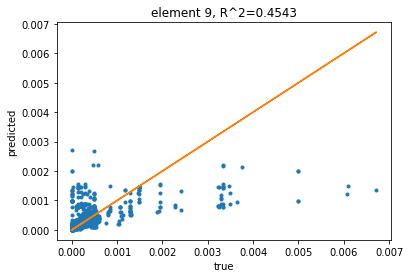

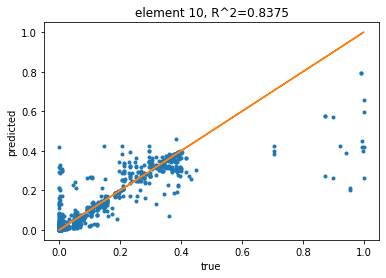

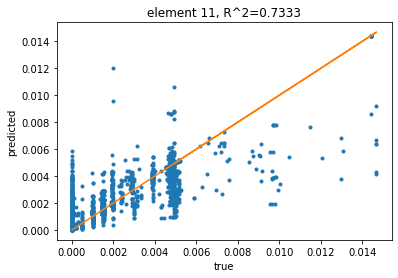

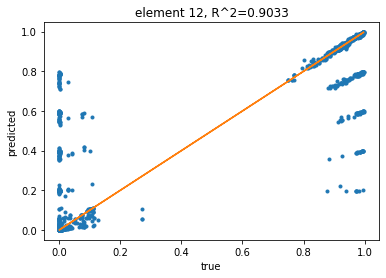

In [33]:
m = train_KNN(X, Y)

Y_pr = m.predict(X)

Y_pr = normalize_results(Y_pr)

print(f'MSE : {mean_squared_error(Y, Y_pr)}')    

Y_true = np.array(Y)
Y_pred = np.array(Y_pr)

for i in range(12):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'{Y_name[i]}, R^2={R_2:.4f}')
    plt.show()